<a href="https://colab.research.google.com/github/Kobajojn/FYRP_U-Net_Architecture/blob/main/U_net_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [121]:
!pip install tacoreader rasterio

2025-10-14 14:29:06,119 matplotlib.image WARNING:	Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.14400000000000002..1.4316].


image size (13, 508, 508)
label size (1, 508, 508)


Text(0.5, 1.0, 'Dataset label')

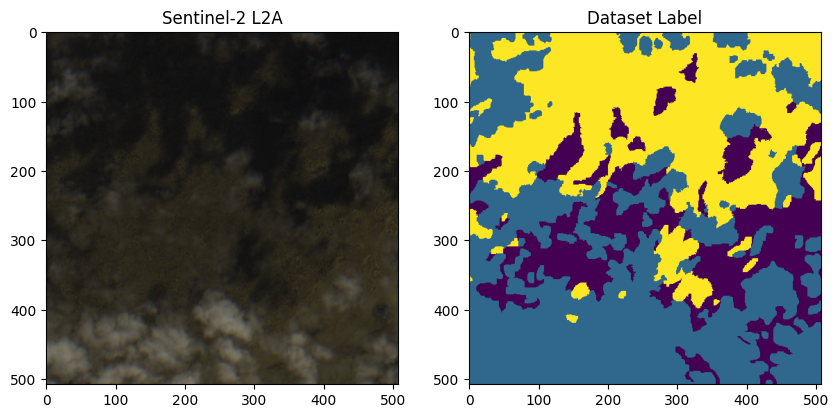

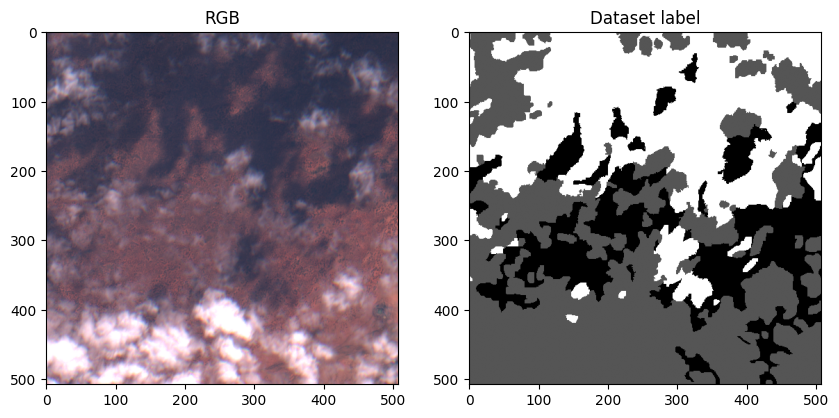

In [122]:
# Setup and accessing CloudSEN12+
# TODO REWRITE WHOLE SECTION - COPIED

import logging
import matplotlib.pyplot
import numpy
import tacoreader
import rasterio as rio
import torch
import torch.nn as nn

# Select one image from the test dataset
ds = tacoreader.load("tacofoundation:cloudsen12-l1c")
# todo remove
# subset = ds[(ds["tortilla:data_split"] == "test") & (ds["label_type"] == "high") & (ds["real_proj_shape"] == 509)] #splits the file into segments - rewrite - from tacoreader library

# Read only one sample
sample_idx = 272
s2_l1c = ds.read(sample_idx).read(0)
s2_label = ds.read(sample_idx).read(1)

# Debug iteration
with rio.open(s2_l1c), rio.open(s2_label):
    s2_l1c_data = rio.open(s2_l1c).read(window = rio.windows.Window(0, 0, 508, 508)) / 10000
    s2_label_data = rio.open(s2_label).read(window = rio.windows.Window(0, 0, 508, 508))
    print("image size", s2_l1c_data.shape) #todo - clipped to 13, 508, 508
    print("label size", s2_label_data.shape) #todo - clipped to 1, 508, 508

# TODO make more colour representative - find what channel represents what
# Combine selective channels to form RGB image - source: https://sciencenotes.org/visible-light-spectrum-wavelengths-and-colors/
# red         625 - 700 nm
# green       500 - 565 nm
# light blue  484 - 500 nm
# dark blue   450 - 484 nm
rgb = numpy.dstack((
    s2_l1c_data[4][:][:],
    s2_l1c_data[3][:][:],
    s2_l1c_data[2][:][:]
  ))
rgb_manual = numpy.moveaxis(s2_l1c_data[[3, 2, 1]], 0, -1) * 3

# Display
fig, ax = matplotlib.pyplot.subplots(1, 2, figsize = (10, 5))
ax[0].imshow(rgb)
ax[0].set_title("Sentinel-2 L2A")
ax[1].imshow(s2_label_data[0], cmap = "viridis") # see https://matplotlib.org/stable/users/explain/colors/colormaps.html
ax[1].set_title("Dataset Label")


rgb_manual = numpy.moveaxis(s2_l1c_data[[3, 2, 1]], 0, -1) * 3

# Graphing image with human determined labels
datapoint_rgb = numpy.moveaxis(s2_l1c_data[[3, 2, 1]], 0, -1) * 3  #REWRITE - ensure that the dimensionality exploited is the colour channels #TODO understand technique
fig, ax = matplotlib.pyplot.subplots(1, 2, figsize = (10, 5))
ax[0].imshow(datapoint_rgb)
ax[0].set_title("RGB")
ax[1].imshow(s2_label_data[0], cmap="gray")
ax[1].set_title("Dataset label")


In [123]:
# initalise and set up the logger application
logger = logging.getLogger(__name__)

logging.basicConfig(
    #filename = "logging.txt",  # logger is saved to file instead of shown on the console
    encoding = "ASCII",
    format = "%(asctime)s %(name)s %(levelname)s:\t%(message)s",
    level = logging.INFO,
    force = True
)

# Misc Functions

In [124]:
def tensor_info(tensor_input, tensor_name):
  """
  Prints off a list of the tensor's details including:  \
    Datatype, Shape, Size, and the device location stored in memory

  foward() Args:
    tensor_input (tensor) - tensor to be examined.
    tensor_name (string) - a string description of the tensor used for descriptive purposes

  return:
    None
  """
  logger.info(f"Tensor:\t\t\t{tensor_name}")
  logger.info(f"Output Datatype:\t{tensor_input.dtype}")
  logger.info(f"Output Shape:\t\t{tensor_input.shape}")
  logger.info(f"Output Size:\t\t{tensor_input.size()}")
  logger.info(f"Output Device:\t\t{tensor_input.device}"
      f"\n--------------------------------------------------------\n")
  return None

In [125]:
def mash_colour_channel(img):
  """
  Generate a greyscale image of a tensor with more than 3 colour/feature channels. \
    Use primarily for visualisation and debugging purposes of prior transformations.

  foward() Args:
    img (tensor) - The input image. Image format is [z, x, y] or [w, u, v]. \
      2D images can also used used in format [x, y] or [u, v]

  return:
    None
  """
  # uses ".unsqueeze(0)" to add an extra dimension for 2D images.
  if img.dim() == 2:
    img = img.unsqueeze(0)

  # Temporary - converts from Tensor to numpy - TODO: understand why detach is needed
  # Move the tensor to CPU (if on Cuda/GPU) before converting to numpy
  img = img.detach().cpu().numpy()
  z_size = img.shape[0] # Gathers the size of the z or colour element

  # averages out the colour channel elementwise - main transformation of function
  img_no_colour = numpy.mean(a = img, axis = 0)

  # print the image
  if z_size == 13:
    logger.debug("verified 13 channel image (raw image input)")
    # create a grey scale and colour scale image - todo be further extensively modified
    fig, ax = matplotlib.pyplot.subplots(1, 2, figsize = (10, 5))

    img_colour = numpy.moveaxis(img[[3, 2, 1]], 0, -1) * 3 # need to further investigate todo

    ax[0].set_title("greyscale img")
    ax[0].imshow(img_no_colour)
    ax[1].set_title("coloured img")
    ax[1].imshow(img_colour)

  else:
    logger.debug("verified as non-13 channel image/label") # just determine the greyscale image
    # Change label depending on image size
    if z_size == 1:
      text = "1 channel data (label)"
    else:
      text = "non-standard data"

    fig = matplotlib.pyplot.figure() # create a new figure to seperate output from previous data
    matplotlib.pyplot.gray() # place the image output into greyscale
    fig.suptitle(text)
    matplotlib.pyplot.imshow(img_no_colour)
    matplotlib.pyplot.show()

  # display image dimension characteristics
  logger.info(f"The image resolution is {img_no_colour.shape}")
  logger.info(f"The number of colour channels are {z_size}")
  return None

2025-10-14 14:29:06,951 matplotlib.image WARNING:	Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.14400000000000002..1.4316].
2025-10-14 14:29:06,957 __main__ INFO:	The image resolution is (508, 508)
2025-10-14 14:29:06,958 __main__ INFO:	The number of colour channels are 13


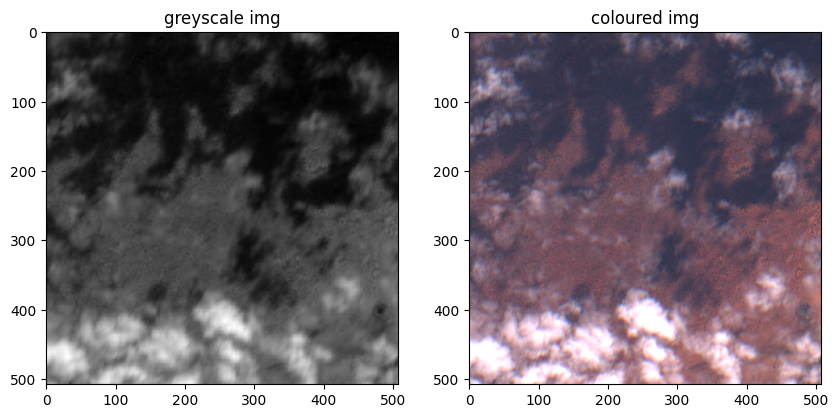

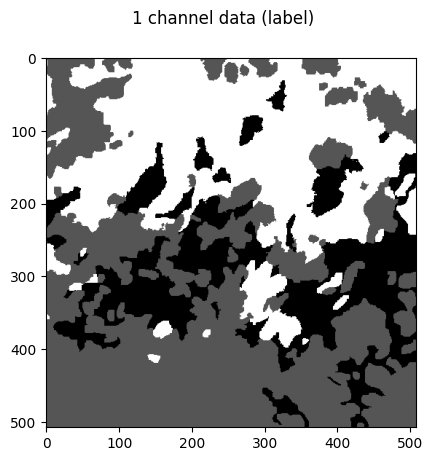

2025-10-14 14:29:07,443 __main__ INFO:	The image resolution is (508, 508)
2025-10-14 14:29:07,445 __main__ INFO:	The number of colour channels are 1


In [126]:
# debug test of above function todo remove

mash_colour_channel(torch.tensor(s2_l1c_data))
mash_colour_channel(torch.tensor(s2_label_data))


# Encoder Layer

In [127]:
# Selecting either a GPU or CPU to run system on
if torch.cuda.is_available():
  device = torch.device("cuda") # For GPU operation
else:
  device = torch.device("cpu")
logger.info(f"The pyTorch code will be ran on the {device = }.")


# ENCODER LAYER - going "down the U"; i.e decreasing the resolution at the for more colour channels

class conv_layer(nn.Module):
  """
  Decreases the spatial resolution of the image for more colour/feature channels.
    Used in both encoder and decoder segments.
    Applies a convolution (3x3) and ReLU to the image twice to the image.
    1x convolution reduces the resolution by 2 pixels and 2x the colour channels.

  class() Args:
    channels_in (int) - The no. of colour/feature channels of the input img.
  foward() Args:
    img (tensor float32) - The input image. Image format is [z, x, y] or [w, u, v]

  return:
    output (tensor float32) - The output image after transformations.
  """
  def __init__ (self, channels_in, up_sample = True): # Parameters go here!
    super().__init__()

    if up_sample:
      out_channels = channels_in * 2
    else:
      out_channels = int(channels_in / 2)

    # Convolution 1 - a sliding window function
    self.conv1 = nn.Conv2d(
        in_channels = channels_in,
        out_channels = out_channels,
        kernel_size = 3,
        stride = 1,
        # padding = 1,                    # padded with zeros to ensure dimensions are always even
        # padding_mode = 'zeros',         # [30] recommends an unpadded convolution
        # bias = True # defaults to True - is a learned bias to Output
        dtype = torch.float32
    ).to(device)
    # Convolution 2 - a sliding window function
    self.conv2 = nn.Conv2d(
        in_channels = out_channels,
        out_channels = out_channels,
        kernel_size = 3,
        stride = 1,
        dtype = torch.float32
    ).to(device)
    # Rectified Linear Unit 1 - A non-linear activation function
    self.relu = nn.ReLU().to(device)

  def forward(self, img):
    output = self.conv1(img)
    output = self.relu(output)
    output = self.conv2(output)
    output = self.relu(output)
    return output


class encoder_layer(nn.Module):
  """
  Decreases the spatial resolution of the image for more colour/feature channels.
    Main core segment of the encoder stage.
    Applies a convolution (3x3) and ReLU to the image twice then (2x2) pool to the image.

    1x pooling downsamples the resolution by x0.5.

  class() Args:
    channels_in (int) - The no. of colour/feature channels of the input img.
  foward() Args:
    img (tensor float32) - The input image. Image format is [z, x, y] or [w, u, v]

  return:
    postpool_output (tensor float32) - The output image after pooling.
    prepool_output (tensor float32) - The output image before pooling. Used in concatenation.
  """
  def __init__ (self): # Parameters go here!
    super().__init__()

    # A 2x2 kernal is used, with a stride/offset of 2 pixels
    self.pooling = nn.MaxPool2d(
        kernel_size = (2, 2),
        stride = 2,
    )

  def forward(self, img, channels_in):
    conv_forward = conv_layer(channels_in = channels_in)
    output = conv_forward(img)

    prepool_output = output
    postpool_output = self.pooling(output) # Final transformation to image

    return postpool_output, prepool_output


2025-10-14 14:29:07,458 __main__ INFO:	The pyTorch code will be ran on the device = device(type='cuda').


# Decoder Layer

In [128]:
# DECODER LAYER - going "up the U"; i.e increasing the resolution at the expense of less colour channels

class decoder_layer(nn.Module):
  """
  Increases the spatial resolution of the image for less colour/feature channels.
    Apply a (2x2) "deconvolution" transformation to counteract the impacts of pooling and convolution.
    Then a "concatenation_feature()" is applied to double colour channel size.
    The main building block of the decoder side of the U-net model.
    1x deconvolution increases the resolution 2x and the colour channels by x0.5.
    1x "concatenation_features()" to the image (doubles colour channel)

  class() Args:
    channels_in (int) - The no. of colour/feature channels of the input img.

  crop_and_concat() Args:
    img_decoder (tensor float32) - Deconvoluted image from decoder side.
      Image format is [z, x, y] or [w, u, v].
      Only works if [x, y] dimensions are EVEN.
    img_encoder_skip (tensor float32) - Pooled image from encoder side. Larger than img_deconv
      Image format is [z, x, y] or [w, u, v]

  foward() Args:
    img (tensor) - The input image. Image format is [z, x, y] or [w, u, v]

  return:
    output (tensor) - The increased spatial resolution image.
  """
  def __init__ (self, channels_deconv_in):
    super().__init__()

    self.deconv1 = nn.ConvTranspose2d(
        in_channels = channels_deconv_in,
        out_channels = int(channels_deconv_in / 2),
        kernel_size = [2, 2], # Deconvolute the image with a 2x2 kernal
        stride = 2,           # to significantly increase the resolution
        dtype = torch.float32
    ).to(device)

  def crop_and_concat(self, img_decoder, img_encoder_skip):
    """
    Doubles the feature channels of its input image.
      Crops prepool_output from the encoder layer and then concatenates its colour/
      feature channels with the decoder's respective deconvoluted image.

    Args:
      img_decoder (tensor float32) - Deconvoluted image from decoder side.
        Image format is [z, x, y] or [w, u, v].
        Only works if [x, y] dimensions are EVEN.
      img_encoder_skip (tensor float32) - Pooled image from encoder side. Larger than img_deconv
        Image format is [z, x, y] or [w, u, v]

    Returns:
      img_concat (tensor float32) - image with double the inputs colour channels
    """
    # Determining the range of the cropping
    size_difference =  img_encoder_skip.shape[1] - img_decoder.shape[1]
    logger.debug(f"size_difference = {size_difference}")
    logger.debug(f"img_encoder_skip.shape = {img_decoder.shape}")
    logger.debug(f"img_decoder.shape = {img_decoder.shape}")

    lower_range = int(size_difference / 2)
    upper_range = img_decoder.shape[1] + lower_range

    # Only works if dimensions are even
    if size_difference % 2 == 0:
      logger.debug(f"The image dimensions are EVEN. Thus cropping can be applied.")

      # Crop the encoded image to fit the resolution of the reduced (in dimensions) decoded image
      img_encoder_crop = img_encoder_skip[:, lower_range:upper_range, lower_range:upper_range]
      # tensor_info(img_decoder, "[ORIGINAL] img_decoder")
      # tensor_info(img_encoder_crop, "[CROPPED] img_encoder_crop")

      # concatenate the colour/feature channels of the encoder and decoder imgs.
      img_concat = torch.cat(tensors = (img_decoder, img_encoder_crop), dim = 0)
      # tensor_info(img_concat, "[COMBINED] img_concat (combined colour channels)")
      # mash_colour_channel(img_concat)

      return img_concat

    else:
      logger.info(f"The image dimensions are ODD. Thus cropped can NOT be applied."
        f"Please crop the image for a EVEN dimension.")
      return None

  def forward(self, img_decoder, img_encoder_skip, channels_in):
    # deconvolute (decrease features, increasing x,y size) + crop and concatenate (x2 feature channels)
    output = self.deconv1(img_decoder)
    output = self.crop_and_concat(img_decoder = output, img_encoder_skip = img_encoder_skip)

    # Apply 2x convolutions + 2x ReLU
    conv_layer_1 = conv_layer(channels_in = channels_in, up_sample = False)
    output = conv_layer_1(output)
    return output

# Bringing it all together

In [129]:
""" ---VARIABLE NAMING NOMENCLATURE:---
- Alphabetical images correspond to which layer the image was generated on.
e.g. B_pooled is on layer 2.
- "X_pooled" are images generated with 2x2 pooling applied.
- "X_concat" are images generated before pooling. This are for concatenation later.
"""

class u_net(nn.Module):
  """
  Increases the spatial resolution of the image for less colour/feature channels.
    Applies the U-net architecture complete via prior defined piecemeal functions.

  class() Args:
    channels_in (int) - The no. of colour/feature channels of the input img.

  crop_and_concat() Args:
    img_decoder (tensor float32) - Deconvoluted image from decoder side.
      Image format is [z, x, y] or [w, u, v].
      Only works if [x, y] dimensions are EVEN.

  foward() Args:
    img (tensor) - The input image. Image format is [z, x, y] or [w, u, v]

  return:
    output (tensor) - The increased spatial resolution image.
  """
  def __init__ (self, ):
    super().__init__()
    # ---------------------------------------------------------
    # Instantiate and initialise each layer
    # Encoder Layer instantiation
    self.encoder_layer_1 = encoder_layer().to(device)
    # Bottleneck Layer instantiation
    self.bottleneck_layer = conv_layer(channels_in = 208).to(device)
    # Decoders instantiation
    self.decoder_layer_0 = decoder_layer(channels_deconv_in = 416).to(device)
    self.decoder_layer_1 = decoder_layer(channels_deconv_in = 208).to(device)
    self.decoder_layer_2 = decoder_layer(channels_deconv_in = 104).to(device)
    self.decoder_layer_3 = decoder_layer(channels_deconv_in = 52).to(device)
    self.decoder_layer_4 = decoder_layer(channels_deconv_in = 26).to(device)
    # Final Layer instantiation
    self.final_layer = conv_layer(channels_in = 26, up_sample = False).to(device)
    # ---------------------------------------------------------
    # TODO - remove if unneeded - included as debug 08.10.2025
    self.flatten_final_layer = nn.Conv2d(
          in_channels = 13,
          out_channels = 1,
          kernel_size = 3,
          stride = 1,
    ).to(device)

  def forward(self, img):

    # Apply image to instantiated layers
    # Encoder layer
    A_pooled, A_concat = self.encoder_layer_1(img, channels_in = 13)
    B_pooled, B_concat = self.encoder_layer_1(A_pooled, channels_in = 26)
    C_pooled, C_concat = self.encoder_layer_1(B_pooled, channels_in = 52)
    D_pooled, D_concat = self.encoder_layer_1(C_pooled, channels_in = 104)

    # Bottleneck layer
    E_bottleneck = self.bottleneck_layer(D_pooled)

    # Decoder Layer
    D_deconv = self.decoder_layer_0(
        img_decoder = E_bottleneck,
        img_encoder_skip = D_concat,
        channels_in = 416
    )
    C_deconv = self.decoder_layer_1(
        img_decoder = D_deconv,
        img_encoder_skip = C_concat,
        channels_in = 208
    )
    B_deconv = self.decoder_layer_2(
        img_decoder = C_deconv,
        img_encoder_skip = B_concat,
        channels_in = 104
    )
    A_deconv = self.decoder_layer_3(
        img_decoder = B_deconv,
        img_encoder_skip = A_concat,
        channels_in = 52
    )
    # Final Layer
    Final_output = self.final_layer(A_deconv)
    Final_output = self.flatten_final_layer(Final_output) # todo 08.10.2025 addition
    return Final_output

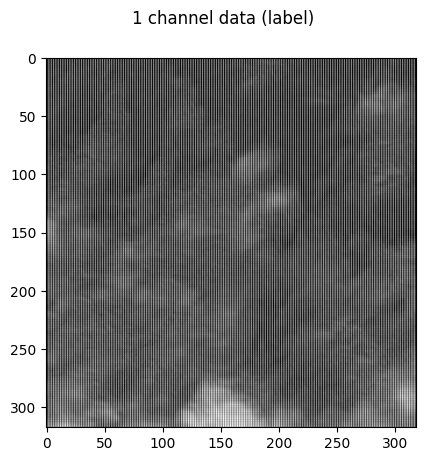

2025-10-14 14:29:07,715 __main__ INFO:	The image resolution is (318, 318)
2025-10-14 14:29:07,716 __main__ INFO:	The number of colour channels are 1


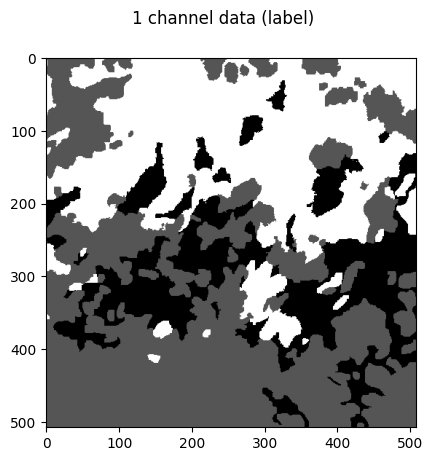

2025-10-14 14:29:07,862 __main__ INFO:	The image resolution is (508, 508)
2025-10-14 14:29:07,863 __main__ INFO:	The number of colour channels are 1
2025-10-14 14:29:07,894 matplotlib.image WARNING:	Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.144..1.4316].
2025-10-14 14:29:07,898 __main__ INFO:	The image resolution is (508, 508)
2025-10-14 14:29:07,899 __main__ INFO:	The number of colour channels are 13


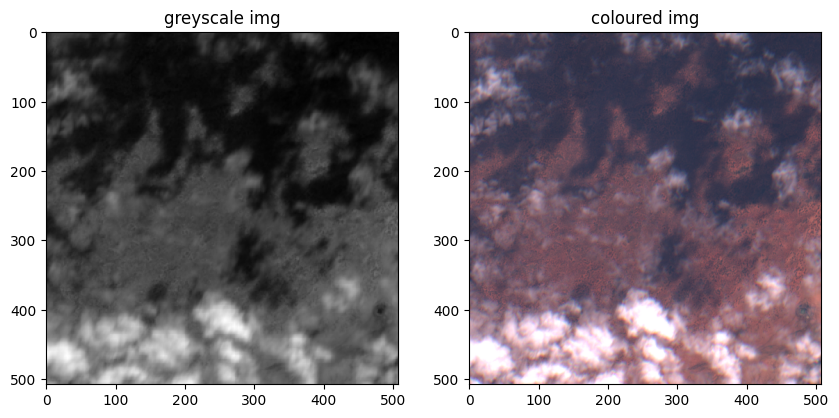

In [130]:
# Image preprocessing
#s2_l1c_data_tensor = torch.from_numpy(s2_l1c_data)
s2_l1c_data_tensor = torch.from_numpy(s2_l1c_data)
s2_l1c_data_tensor = s2_l1c_data_tensor.to(torch.float32)
s2_l1c_data_tensor = s2_l1c_data_tensor.to(device)
# Crop image such that after 8 convolutions are 4 poolings, so that the dimensions are always even
# s2_l1c_data_tensor = s2_l1c_data_tensor[:, 0:508, 0:508]

# Apply everything via the U-net architecture
u_net_arch = u_net().to(device)
img_out = u_net_arch(s2_l1c_data_tensor)

mash_colour_channel(img_out)
mash_colour_channel(torch.tensor(s2_label_data))
mash_colour_channel(s2_l1c_data_tensor)

# Training Stage Sandpit

# Execution of Model

In [131]:
# Sanity Check: Display u-net architecture's parameters
u_net_arch = u_net().to(device) # Reinitialise u_net model
logger.debug(f"{list(u_net_arch.parameters()) = }")

# Loading, Sorting, and Processing Training Stage Data


## Load Data 1

In [132]:
# Preparation for auto iterating and downloading requesite data
l1c_fileNames = [
    "cloudsen12-l1c.0000.part.taco", # Installed - 2025.10.01
    "cloudsen12-l1c.0001.part.taco", # Installed - 2025.10.01
    "cloudsen12-l1c.0002.part.taco", # --
    "cloudsen12-l1c.0003.part.taco", # --
    "cloudsen12-l1c.0004.part.taco"  # --
  ]

from huggingface_hub import hf_hub_download
import os.path

# Searches for imported datasets. If none are found download
if os.path.isfile("/content/datasets/cloudsen12-l1c.0001.part.taco") == False:
  logger.info(f"The requisite datasets have not been installed.\n\t\t\t\t\t"
      "Please wait until the datasets is been installed from huggingface.\n\t\t\t\t\t"
      "This will take a long time approximately 5+ minutes")

  # 20GB download requires significant time - execute sparingly takes roughly 5 minutes to fully execute
  # Downloads data from huggingface and stores it in Colab file system which is reset on every startup
  # dataset_0 = hf_hub_download(
  #     "tacofoundation/cloudsen12",
  #     "cloudsen12-l1c.0000.part.taco",
  #     repo_type = "dataset",
  #     revision = "f9490f7de11b4f387f72ef800e73ccbb754711de",
  #     local_dir = "/content/datasets" # Path to save dataset on Colab
  # )
  # logger.info(f"cloudsen12-l1c.0000.part.taco has been installed.")
  # ----------------------------------------------------------------------------
  # TODO is this required?
  # dataset_1 = hf_hub_download(
  #     "tacofoundation/cloudsen12",
  #     "cloudsen12-l1c.0001.part.taco",
  #     repo_type = "dataset",
  #     revision = "f9490f7de11b4f387f72ef800e73ccbb754711de",
  #     local_dir = "/content/datasets" # Path to save dataset on Colab
  # )
  logger.info(f"cloudsen12-l1c.0001.part.taco has been installed.")
  logger.info(f"The requisite datasets have been installed.")
else:
  logger.info(f"The requisite datasets have already been been installed.\n\t\t\t\t\t"
      "No further action is required.")
  # Ensure that the file is referenced in the local variable memory - TODO
  #with open("/content/datasets/cloudsen12-l1c.0000.part.taco") as file:
  #  exec(dataset1 = file)


# TODO
  # #from googleapiclient.http import MediaFileUpload
  # import googleapiclient
  # import googleapiclient.discovery
  # drive_service = googleapiclient.discovery.build('drive', 'v3')

  # file_metadata = {
  #   'name': 'cloud_training_data',
  #   'mimeType': 'text/plain'
  # }
  # media = googleapiclient.http.MediaFileUpload(
  #     '/content/datasets/cloudsen12-l1c.0000.part.taco',
  #     mimetype = 'text/plain',
  #     resumable = True
  #   )
  # created = drive_service.files().create(
  #     body=file_metadata,
  #     media_body=media,
  #     fields='id'
  #   ).execute()

  # print('File ID: {}'.format(created.get('id')))
  # #https://colab.research.google.com/notebooks/io.ipynb?hl=en#scrollTo=r5X77CZ5_G-C

2025-10-14 14:29:08,472 __main__ INFO:	The requisite datasets have already been been installed.
					No further action is required.


## Load Data 2

In [133]:
# Load data into one massive variable - split afterwards into seperate training and testing data
# file = ["/content/datasets/cloudsen12-l1c.0000.part.taco", "/content/datasets/cloudsen12-l1c.0001.part.taco"]

# DATA = tacoreader.load(["/content/datasets/cloudsen12-l1c.0001.part.taco"])
# ds = DATA
DATA = tacoreader.load("tacofoundation:cloudsen12-l1c")

2025-10-14 14:29:12,590 matplotlib.image WARNING:	Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1824..1.0476].
2025-10-14 14:29:12,595 __main__ INFO:	The image resolution is (508, 508)
2025-10-14 14:29:12,596 __main__ INFO:	The number of colour channels are 13


debug (13, 508, 508)
debug (1, 508, 508)


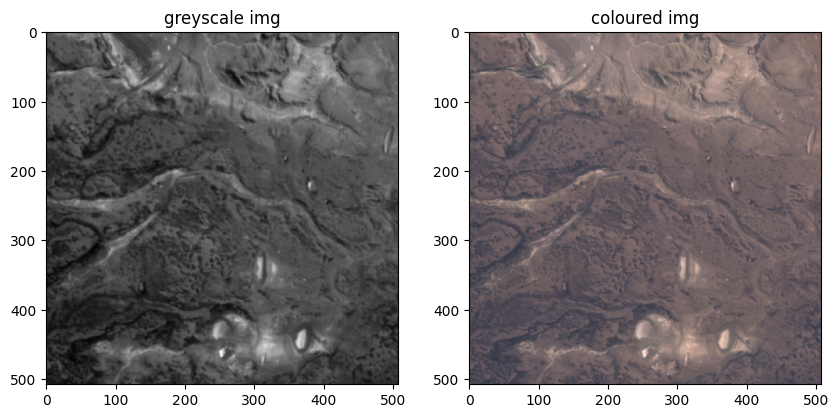

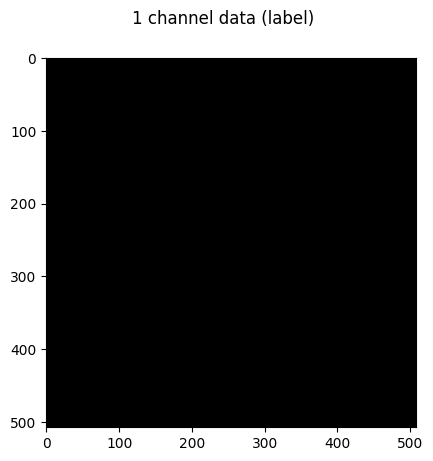

2025-10-14 14:29:13,066 __main__ INFO:	The image resolution is (508, 508)
2025-10-14 14:29:13,066 __main__ INFO:	The number of colour channels are 1
2025-10-14 14:29:14,227 matplotlib.image WARNING:	Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1512..2.286].
2025-10-14 14:29:14,234 __main__ INFO:	The image resolution is (508, 508)
2025-10-14 14:29:14,235 __main__ INFO:	The number of colour channels are 13


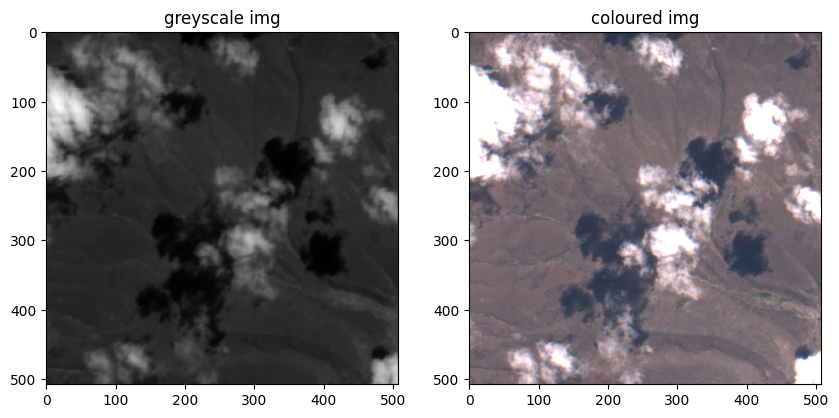

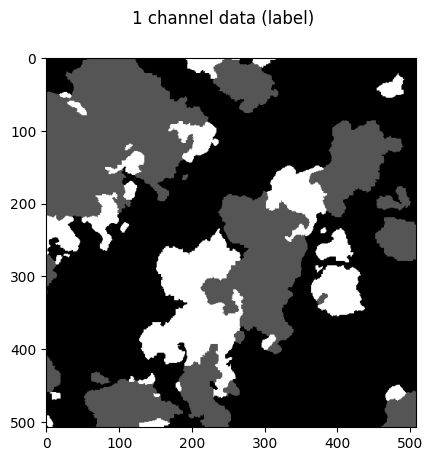

2025-10-14 14:29:14,882 __main__ INFO:	The image resolution is (508, 508)
2025-10-14 14:29:14,884 __main__ INFO:	The number of colour channels are 1


In [134]:
def extract_data(sample_idx):
  """
  Reads only 1 sample from the saved DATA dataset  \
    Datatype, Shape, Size, and the device location stored in memory

  Args:
    sample_idx - a int index for the DATA variable. The DATA is stored in an \
    external scope. It has the whole dataset (training + testing) stored in it.

  return:
    s2_l1c_data - a [13 x 508 x 508] numpy array extracted from DATA
    s2_label_data - a [1 x 508 x 508] numpy array extracted from DATA
  """
  img_data = DATA.read(sample_idx).read(0)
  lbl_data = DATA.read(sample_idx).read(1)

  # Retrieve the data TODO remove
  # with rio.open(img_data) as src, rio.open(lbl_data) as dst:
      # s2_l1c_data = src.read([4, 3, 2],window = rio.windows.Window(0, 0, 512, 512))
      # s2_label_data = dst.read(window=rio.windows.Window(0, 0, 512, 512))

  with rio.open(img_data), rio.open(lbl_data):
    # Image input is 508x508 pixels so that u-net works best
    s2_l1c_data = rio.open(img_data).read(window = rio.windows.Window(0, 0, 508, 508)) / 10_000  # (13, 512, 512) ndarray (numpy)
    s2_label_data = rio.open(lbl_data).read(window = rio.windows.Window(0, 0, 508, 508))

  # Output relevant datasets
  return s2_l1c_data, s2_label_data

img, label = extract_data(sample_idx = 4)


print("debug", numpy.shape(img))
print("debug", numpy.shape(label))
#
mash_colour_channel(torch.from_numpy(img))
mash_colour_channel(torch.from_numpy(label))

img, label = extract_data(sample_idx = 7)

mash_colour_channel(torch.from_numpy(img))
mash_colour_channel(torch.from_numpy(label))

label1 = numpy.squeeze(label)

## Sort Data

In [135]:
# The code done here follows the example methodologies shown in introduction to PyTorch

# Problem breakdown and requirements:

#   Need to import training data
#   -> breakdown into training and testing datasets
#   -> datasets must be cropped and converted into valid filetype
#   Need to import labels
#   -> datatype?
#   -> labels must be cropped and converted into valid filetype

# Need to evaluate success and labels

# WORK IN PROGRESS
#   Define the working datasets:
#   TODO CHECK DIMENSIONS
#   imported datasets are: img [z,x,y,i?], labels [x,y,i?]

#   Relies on assumptions of the quality of the imported data

# Train and testing ratio
DATASET_AMOUNT = 100 #80
tt_ratio = 0.8
TRAIN_AMOUNT = int(DATASET_AMOUNT * tt_ratio)
TEST_AMOUNT = DATASET_AMOUNT - TRAIN_AMOUNT

# Preallocate memory for traing and testing datasets
train_img = numpy.empty(shape = (TRAIN_AMOUNT, 13, 508, 508))
train_img.fill(None)

train_label = numpy.empty(shape = (TRAIN_AMOUNT, 508, 508))
train_label.fill(None)

test_img = numpy.empty(shape = (TEST_AMOUNT, 13, 508, 508,))
test_img.fill(None)

test_label = numpy.empty(shape = (TEST_AMOUNT, 508, 508,))
test_label.fill(None)

# Splits and seperates the data into traing and testing segments
for i in range(DATASET_AMOUNT):
  img_in, label_in = extract_data(sample_idx = i)

  # store into training and testing
  if i < TRAIN_AMOUNT:
    train_img[i][:][:][:] = img_in
    train_label[i][:][:] = label_in
    logger.debug(f"{i} train")
  else:
    test_img[i - TRAIN_AMOUNT][:][:][:]  = img_in
    test_label[i  - TRAIN_AMOUNT][:][:] = label_in
    logger.debug(f"{i} test")

# Convert to tensors!
train_img = torch.from_numpy(train_img)
train_label = torch.from_numpy(train_label)
test_img = torch.from_numpy(test_img)
test_label = torch.from_numpy(test_label)
# Convert to standard float32 tensors! and move to operational device
train_img = train_img.to(torch.float32).to(device)
train_label = train_label.to(torch.float32).to(device)
test_img = test_img.to(torch.float32).to(device)
test_label = test_label.to(torch.float32).to(device)

# Resulting tensors
tensor_info(train_img, "combined train_img data")
tensor_info(train_label, "combined train_label data")
tensor_info(test_img, "combined test_img data")
tensor_info(train_label, "combined train_label data")

# -----------------------------------------------------------------------------------------------------------
# TODO Accessing data recommendations: "https://colab.research.google.com/drive/1U9n40rwdnn73bdWruONA3hIs1-H3f74Q"

2025-10-14 14:31:19,564 __main__ INFO:	Tensor:			combined train_img data
2025-10-14 14:31:19,565 __main__ INFO:	Output Datatype:	torch.float32
2025-10-14 14:31:19,566 __main__ INFO:	Output Shape:		torch.Size([80, 13, 508, 508])
2025-10-14 14:31:19,567 __main__ INFO:	Output Size:		torch.Size([80, 13, 508, 508])
2025-10-14 14:31:19,568 __main__ INFO:	Output Device:		cuda:0
--------------------------------------------------------

2025-10-14 14:31:19,569 __main__ INFO:	Tensor:			combined train_label data
2025-10-14 14:31:19,570 __main__ INFO:	Output Datatype:	torch.float32
2025-10-14 14:31:19,571 __main__ INFO:	Output Shape:		torch.Size([80, 508, 508])
2025-10-14 14:31:19,572 __main__ INFO:	Output Size:		torch.Size([80, 508, 508])
2025-10-14 14:31:19,573 __main__ INFO:	Output Device:		cuda:0
--------------------------------------------------------

2025-10-14 14:31:19,573 __main__ INFO:	Tensor:			combined test_img data
2025-10-14 14:31:19,574 __main__ INFO:	Output Datatype:	torch.float32


In [136]:
# For Debug
def view_img(index_i, img_bundle, img_bundle_name):
  """
  Used for debug. Prints an index image from a image bundle (which is generated \
    from the DATA variable.

  Args:
    index_i (unsigned int) -  the index of the desired image from the bundle. \
      Please ensure the index is within the bundle's overall size (less than X).
    img_bundle (numpy array) - a collection of images (not labels) used for \
      training / testing. Dimensions are [X][Y][A][A]. X is amount of images, \
      Y is the no. channels, A is the image resolution (less than or equal to 508)
    img_bundle_names (str) - name of the bundle for debug

  return:
    None
  """
  tensor_info(img_bundle[index_i][:][:][:], "img_bundle_name " + str(index_i))
  mash_colour_channel(img_bundle[index_i][:][:][:])
  return None

# view_img(1, train_img, "train_img")
# view_img(7, test_img, "test_img")
# view_img(19, test_img, "test_img")
# view_img(79, train_img, "train_img")

todo 02.10.2025 Thursday W8+1. Finalised 06.10.2025 Monday W9+1

Tried to save data the "stupidest" way possible. Iterate through a dataset - get data individually and then load data to a common array variable.

problems:
- need to sort: geographically, camerawise etc.

# Inference Model

In [193]:
import tqdm
import torchvision.transforms.functional as ttF

# TRAINING_LENGTH = 20 # CONTROLS NUMBER OF TRAINING CYCLES
TRAINING_LENGTH = TRAIN_AMOUNT


# Allow for parameters of model to be randomised.
# weights = nn.Parameter(
#     torch.randn(1, dtype = torch.float32),
#     requires_grad = True
#   )

# loss and optimiser functions
loss_fn = nn.BCEWithLogitsLoss()
# loss_fn = nn.MSELoss()

# optimiser_fn = torch.optim.SGD(
#     params = u_net_arch.parameters(), # parameters to be optimised
#     lr = 0.1 # learning rate (how much the optimizer should change parameters at each step, higher = more (less stable), lower = less (might take a long time))
# )
optimiser_fn = torch.optim.Adam(
    params = u_net_arch.parameters(), # parameters to be optimised
    lr = 0.01 # learning rate (how much the optimizer should change parameters at each step, higher = more (less stable), lower = less (might take a long time))
)


for epoch in tqdm.tqdm(range(TRAINING_LENGTH)):
  # Seed for randomness - keeps the initial parameter values consistent
  torch.manual_seed(27)
  u_net_arch.train() # In Training Mode - Default

  train_img_epoch = train_img[epoch][:][:][:].to(device)
  train_predict = u_net_arch(train_img_epoch) # intiial forward pass of model
  train_predict = torch.squeeze(train_predict) # make 2D, comparable to "training_label"

  # DEBUG
  logger.info(f"{epoch=}")
  # tensor_info(train_predict, epoch) # output for label_predict tensor is [1 (removed), 318, 318]

  # Reduces size from 1x508x508 to 1x318x318 (u-net output) (preprocessing the train_label data)
  train_label_epoch = ttF.resize(train_label[epoch][:][:].unsqueeze(0), size = (318, 318))
  train_label_epoch = train_label_epoch.squeeze(0).to(device) # remove unnecessary dimension # todo clarify

  # loss requires a likewise similar value - need to find alternative method or change inference method
  loss = loss_fn(train_predict, train_label_epoch) # loss value is generated

  optimiser_fn.zero_grad() # optimised via zero grad

  loss.backward() # loss back propagation

  optimiser_fn.step() # progress the optimiser

  # need to find a more appropiate method of training data
  # original example had everything stored in one massive variable which was iterated through by the model
  # current setup requires manually iterating through each instance
  with torch.inference_mode():
    torch.no_grad()
    u_net_arch.eval() # Evaluate and test the model

    for test_epoch in range(TEST_AMOUNT):

      # 1. Forward pass on test data
      test_predict = u_net_arch(test_img[test_epoch][:][:][:])
      test_predict = torch.squeeze(test_predict) # make 2D, comparable to "training_label"

      # 2. Caculate loss on test data

      # 2.1 Resize "test_label" to match "test_pred's" dimensions
      test_label_epoch = ttF.resize(test_label[test_epoch][:][:].unsqueeze(0), size = (318, 318))
      test_label_epoch = test_label_epoch.squeeze(0) # remove unnecessary dimension
      # 2.2 Find loss of model
      test_loss = loss_fn(test_predict, test_label_epoch) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

100%|██████████| 80/80 [00:51<00:00,  1.55it/s]


In [182]:
import datetime

# Find our model's learned parameters ONLY in debug mode
logger.debug("The model learned parameters:")
logger.debug(u_net_arch.state_dict())

# Saves the model's learned parameters (state dictionary) to a file which is timestamped
if os.path.exists("/content/datasets/model_parameters") == False:
  os.mkdir("/content/datasets/model_parameters")

time_stamp = datetime.datetime.now().replace(microsecond = 0).isoformat() # prints out current ISO 8601 UTC time_stamp
u_net_model = "/content/datasets/model_parameters/u_net_" + str(time_stamp) + ".pt"
torch.save(u_net_arch.state_dict(), u_net_model)

# TODO save the state_dict to a directory and download to shorten exercution time 09.10.2025

2025-10-14 15:24:30,161 __main__ INFO:	Tensor:			img_bundle_name 13
2025-10-14 15:24:30,161 __main__ INFO:	Output Datatype:	torch.float32
2025-10-14 15:24:30,162 __main__ INFO:	Output Shape:		torch.Size([13, 508, 508])
2025-10-14 15:24:30,163 __main__ INFO:	Output Size:		torch.Size([13, 508, 508])
2025-10-14 15:24:30,164 __main__ INFO:	Output Device:		cuda:0
--------------------------------------------------------

2025-10-14 15:24:30,189 matplotlib.image WARNING:	Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.3528..1.9368].
2025-10-14 15:24:30,193 __main__ INFO:	The image resolution is (508, 508)
2025-10-14 15:24:30,193 __main__ INFO:	The number of colour channels are 13
2025-10-14 15:24:30,194 __main__ INFO:	Tensor:			img_bundle_name 13
2025-10-14 15:24:30,195 __main__ INFO:	Output Datatype:	torch.float32
2025-10-14 15:24:30,197 __main__ INFO:	Output Shape:		torch.Size([508, 508])
2025-10-14 15:24:30,198 __ma

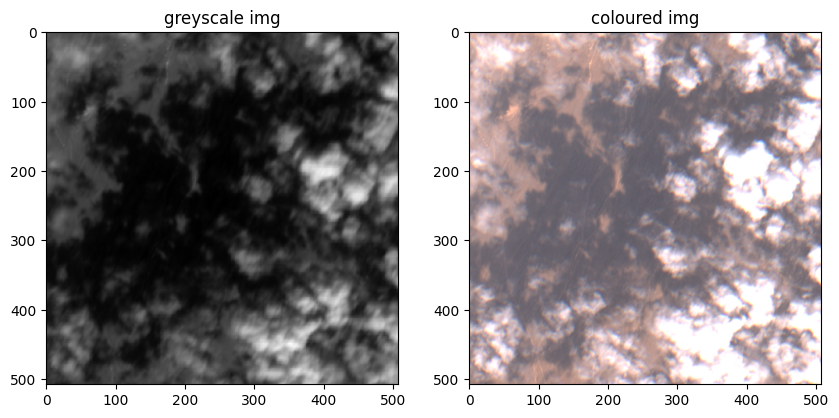

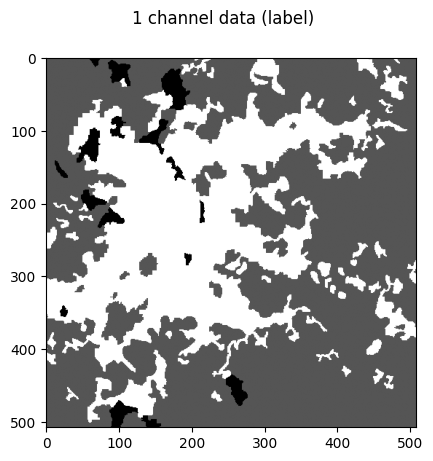

2025-10-14 15:24:30,684 __main__ INFO:	The image resolution is (508, 508)
2025-10-14 15:24:30,685 __main__ INFO:	The number of colour channels are 1


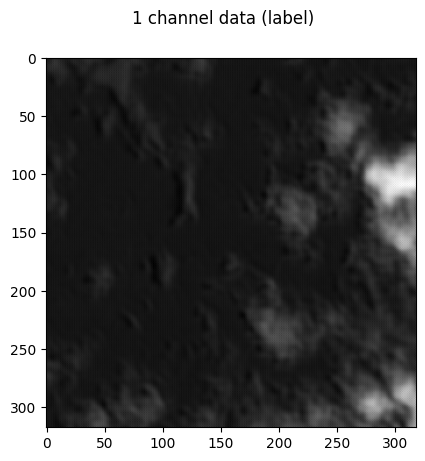

2025-10-14 15:24:30,844 __main__ INFO:	The image resolution is (318, 318)
2025-10-14 15:24:30,846 __main__ INFO:	The number of colour channels are 1


In [190]:
u_net_arch.eval()
torch.no_grad() # gradient is only required for backpropagation and training

# Random seeds https://docs.pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(27)
test_img_index = 13

# Making a prediction - use to evaluate the validity of the dataset
# with torch.inference_mode():

u_net_arch.load_state_dict(torch.load(u_net_model))

label_eval_predict = u_net_arch(test_img[test_img_index][:][:][:])


view_img(test_img_index, test_img, "test_img")
view_img(test_img_index, test_label, "test_label")

mash_colour_channel(label_eval_predict)


# -------------------------------------------------------------------------------
# logger.info(f"The PREDICTED TEST LABEL from the original test image")
# mash_colour_channel(label_eval_predict)

# logger.info(f"The ORIGINAL TEST LABEL")
# mash_colour_channel(test_label[test_img_index][:][:])

# logger.info(f"The ORIGINAL TEST IMAGE")
# img = Image.fromarray(test_img[test_img_index][:][:][:].squeeze().detach().numpy() * 255)
# -------------------------------------------------------------------------------
# # Convert pytorch prediction to a PIL Image
# img = PIL.Image.fromarray(label_eval_predict.squeeze().detach().numpy() * 255)
# #img.show()
# display(img)
# -------------------------------------------------------------------------------
# todo create a overlaping bounding box over the image

# Create a Rectangle patch
# rect = matplotlib.patches.Rectangle(
#     (50, 100),
#     40,
#     30,
#     linewidth = 1,
#     edgecolor = 'r',
#     facecolor = 'none'
#   )
# create graphical method of visualising code

2025-10-14 15:24:37,570 __main__ INFO:	The PREDICTED TEST LABEL from the original test image


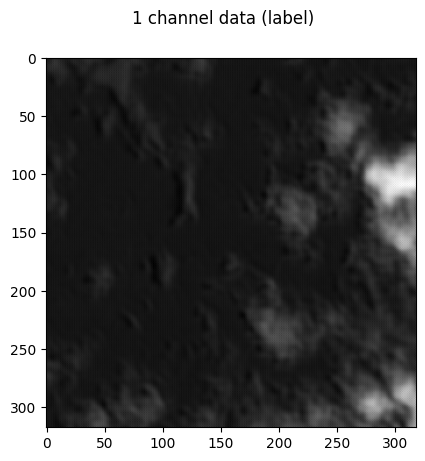

2025-10-14 15:24:37,714 __main__ INFO:	The image resolution is (318, 318)
2025-10-14 15:24:37,716 __main__ INFO:	The number of colour channels are 1
2025-10-14 15:24:37,717 __main__ INFO:	The ORIGINAL TEST LABEL


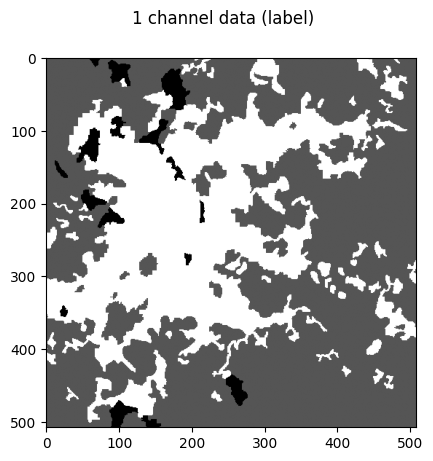

2025-10-14 15:24:37,859 __main__ INFO:	The image resolution is (508, 508)
2025-10-14 15:24:37,861 __main__ INFO:	The number of colour channels are 1
2025-10-14 15:24:37,863 __main__ INFO:	The ORIGINAL TEST IMAGE
2025-10-14 15:24:37,892 matplotlib.image WARNING:	Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.3528..1.9368].
2025-10-14 15:24:37,896 __main__ INFO:	The image resolution is (508, 508)
2025-10-14 15:24:37,897 __main__ INFO:	The number of colour channels are 13


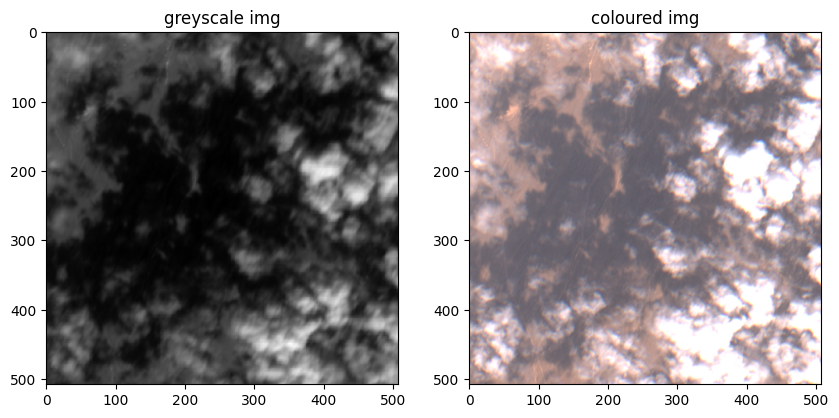

In [191]:
logger.info(f"The PREDICTED TEST LABEL from the original test image")
mash_colour_channel(label_eval_predict)

logger.info(f"The ORIGINAL TEST LABEL")
mash_colour_channel(test_label[test_img_index][:][:])

logger.info(f"The ORIGINAL TEST IMAGE")
mash_colour_channel(test_img[test_img_index][:][:][:])

2025-10-14 15:24:42,622 __main__ INFO:	predicted mask properities: 	 min_val: 0.5141118764877319, max_val: 0.5266731381416321
2025-10-14 15:24:42,623 __main__ INFO:	Tensor:			predicted mask
2025-10-14 15:24:42,624 __main__ INFO:	Output Datatype:	torch.float32
2025-10-14 15:24:42,625 __main__ INFO:	Output Shape:		torch.Size([1, 318, 318])
2025-10-14 15:24:42,626 __main__ INFO:	Output Size:		torch.Size([1, 318, 318])
2025-10-14 15:24:42,627 __main__ INFO:	Output Device:		cpu
--------------------------------------------------------

2025-10-14 15:24:42,704 __main__ INFO:	original mask properities: 	 min_val: 0.0, max_val: 3.0
2025-10-14 15:24:42,704 __main__ INFO:	Tensor:			original mask
2025-10-14 15:24:42,706 __main__ INFO:	Output Datatype:	torch.float32
2025-10-14 15:24:42,706 __main__ INFO:	Output Shape:		torch.Size([508, 508])
2025-10-14 15:24:42,707 __main__ INFO:	Output Size:		torch.Size([508, 508])
2025-10-14 15:24:42,710 __main__ INFO:	Output Device:		cpu
------------------------

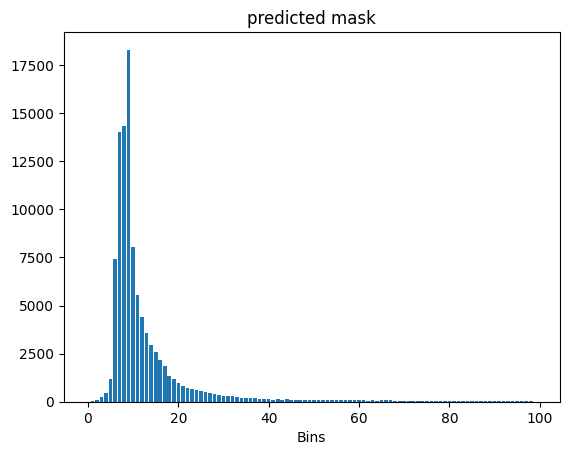

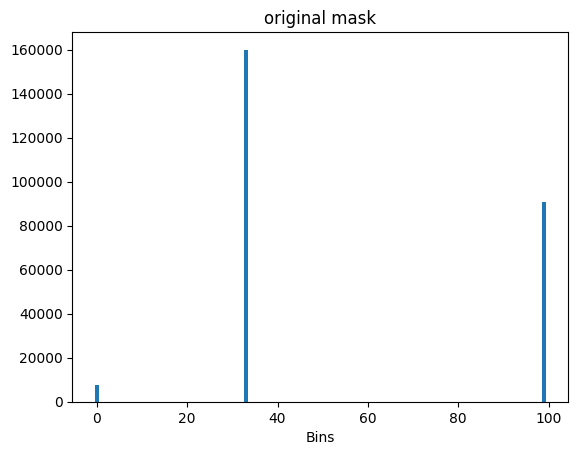

In [192]:
# todo create docstring
def histogram_tensor(img, img_name):
  # plots a histogram based on the image's min and max values
  # requires a tensor. Tensor is sent to the cpu regardless of original location
  # img (tensor X,Y) - img to be analyised, img_name - name of img for the graph


  # move to cpu location
  img_cpu = img
  img_cpu = img_cpu.cpu()

  # Get min and max values of the tensor as a float to develop the histogram
  min_val, max_val = torch.min(img_cpu).item(), torch.max(img_cpu).item()
  # print tensor details
  logger.info(f"{img_name} properities: \t min_val: {min_val}, max_val: {max_val}")
  tensor_info(img_cpu, img_name)

  bins_var = 100
  hist = torch.histc(img_cpu, bins = bins_var, min = min_val, max = max_val)

  # The scale is between min_val and max_val with the increment of bins_var
  x = range(bins_var)
  matplotlib.pyplot.figure()
  matplotlib.pyplot.title(img_name)
  matplotlib.pyplot.bar(x, hist, align='center')
  matplotlib.pyplot.xlabel('Bins')
  return None


histogram_tensor(label_eval_predict, "predicted mask")
histogram_tensor(test_label[test_img_index][:][:], "original mask")


# todo:
todo recommendations:
- use IOU - intersection over union loss class to determine missing values
- aim to minimalise cross-entropy loss - torch.nn.CrossEntropyLoss()

- Adam optimiser is recommended
- lossFunc - BCEWithLogitsLoss()

- Gradients are only used for learning or backpropagating - torch.torch_no_grad()
---
main requirements:

2. determine required images and what I should use
5. Get a logger setup - requires a working file directory
```
import logging
self.logger = logging.getLogger(__name__)

import torchvision.transforms.functional as ttF
# Making Prelabeled image's dimensions equal the predicted image's dimensions.
label1_resize1 = ttF.resize(label1.unsqueeze(0), size = (318, 318))

```

##Useful knowledge:
1. keyboard shortcut to comment and uncomment out things is ctrl + "/"**bold text**
2. The U-net model requires that the encoder/decoder colour channel follows the following pattern: 1 - 64 - 128 - 256 - 512
3. Refer to "https://stackoverflow.com/questions/57530038/concatenation-step-of-u-net-for-unequal-number-of-channels" for more information
4. Unsqueeze 2 dimensional tensors to use the mash_colour_channels() functional (prints off an image in greyscale).
5. > represents a task which has been completed

## CloudSEN12+ dataset information:
(Further information about CloudSEN12+ dataset)

1. The Huggingface website: https://huggingface.co/datasets/tacofoundation/cloudsen12
Explains the overall picture of the dataset types

2. https://www.scidb.cn/en/detail?dataSetId=2036f4657b094edfbb099053d6024b08&version=V1
Explains historical dataset formatting - we are interested in  p509 has some further details. Investigate: *p509-> high -> train*

## Additional References:

Sam Hall's References:
- OBAI Cloud Detection tutorial: https://source.coop/radiantearth/cloud-cover-detection-challenge
- OBAI recommendations independent of ECSS: https://ieeexplore.ieee.org/document/10558221
- Refer to: https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/